In [102]:
import scipy
n = int(1E1)
h = 1./(n+1)
x = np.linspace(h, 1.-h, n)
b_tilde = h**2 * 100*np.exp(-10*x)

# 1b. General solution

In [103]:
# Diagonals
a = np.random.rand(n)
b = np.random.rand(n)
c = np.random.rand(n)

In [104]:
# Solution from library function
A = scipy.sparse.diags([list(a[1:]), list(b), list(c[:-1])], [-1,0,1]).toarray()

In [105]:
%%time
x_lib = np.linalg.solve(A, b_tilde)

CPU times: user 103 µs, sys: 3 µs, total: 106 µs
Wall time: 111 µs


In [106]:
# My implementation
b_mod = np.copy(b)
b_tilde_solution = np.copy(b_tilde)

In [107]:
%%time

# Forward substitution
for i in range(1,n):
    f = a[i]/b_mod[i-1]
    b_mod[i] -= f*c[i-1]
    b_tilde_solution[i] -= f*b_tilde_solution[i-1]

# Solving n-1'th x 
b_tilde_solution[n-1] /= b_mod[n-1]

# Backward substitution
for i in range(n-2, -1, -1):
    b_tilde_solution[i] = (b_tilde_solution[i] - c[i]*b_tilde_solution[i+1])/b_mod[i]

CPU times: user 91 µs, sys: 2 µs, total: 93 µs
Wall time: 98.9 µs


In [108]:
# Controlling result
assert max(x_lib-b_tilde_solution) < 1E-10

## Plots for C++ implementation

In [2]:
closed_form = pd.read_csv("closed-form.csv")
approx10 = pd.read_csv("approx-10.csv")
approx100 = pd.read_csv("approx-100.csv")
approx1000 = pd.read_csv("approx-1000.csv")

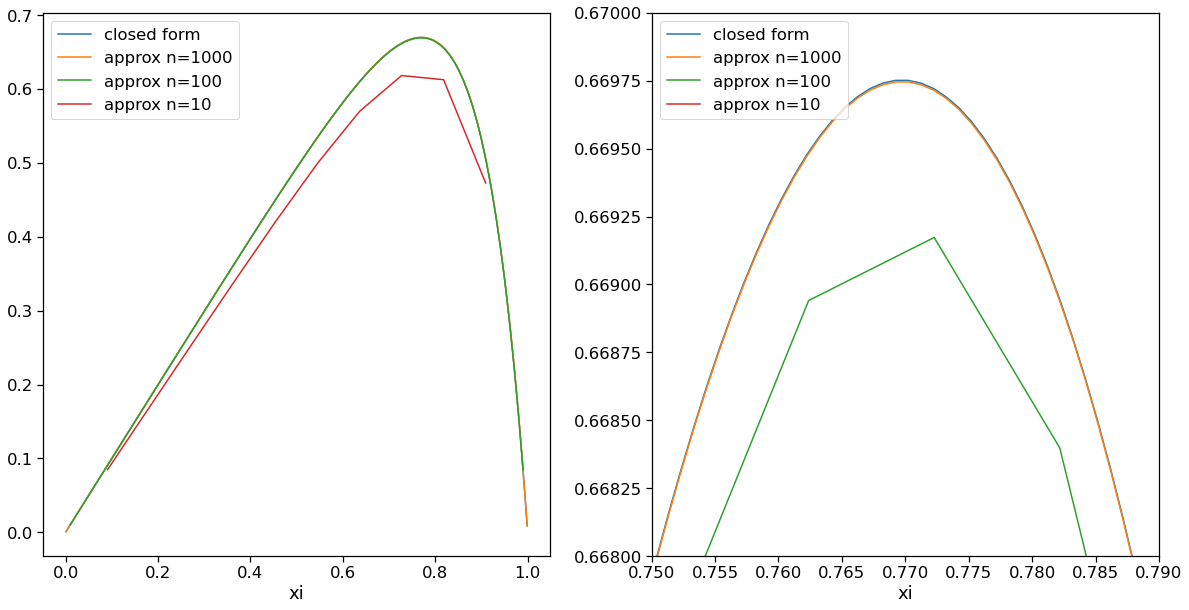

In [62]:
plt.rcParams['figure.figsize'] = [20,10]
fig, axes = plt.subplots(1, 2)
closed_form.plot(ax=axes[0], x=0, y=1,label="closed form")
approx1000.plot(ax=axes[0], x=0, y=1,label="approx n=1000")
approx100.plot(ax=axes[0], x=0, y=1,label="approx n=100")
approx10.plot(ax=axes[0], x=0, y=1,label="approx n=10")
closed_form.plot(ax=axes[1], x=0, y=1,label="closed form")
approx1000.plot(ax=axes[1], x=0, y=1,label="approx n=1000")
approx100.plot(ax=axes[1], x=0, y=1,label="approx n=100")
approx10.plot(ax=axes[1], x=0, y=1,label="approx n=10")
axes[1].set_xlim([.75,.79])
axes[1].set_ylim([.668,.67])
plt.legend(loc='upper left')
plt.savefig("calc-results.png")
plt.show()


# 1c. Specific solution for 2nd derivative

In [109]:
# Solution from library function
a = np.zeros(n)-1
b = np.zeros(n)+2
c = np.zeros(n)-1
A = scipy.sparse.diags([list(a[1:]), list(b), list(c[:-1])], [-1,0,1]).toarray()

In [110]:
%%time
x_lib = np.linalg.solve(A, b_tilde)

CPU times: user 100 µs, sys: 3 µs, total: 103 µs
Wall time: 108 µs


In [111]:
# My implementation
b_tilde_solution = np.copy(b_tilde)

In [112]:
%%time

# Forward substitution of b_tilde only
for i in range(1,n):
    b_tilde_solution[i] = (i+1)*b_tilde_solution[i] + b_tilde_solution[i-1]

# Solving n-1'th x
b_tilde_solution[n-1] /= (n+1)

# Backward substitution is with known factors
for i in range(n-2, -1, -1):
    b_tilde_solution[i] = (b_tilde_solution[i] + (i+1)*b_tilde_solution[i+1])/(i+2)

CPU times: user 53 µs, sys: 0 ns, total: 53 µs
Wall time: 57.7 µs


In [113]:
# Controlling result
assert max(x_lib-b_tilde_solution) < 1E-10

In [26]:
cpu_g = pd.read_csv("cpu-g.csv", index_col=0, header=0, names=['n','tridiag'])
cpu_d = pd.read_csv("cpu-d.csv", index_col=0, header=0, names=['n', 'Poisson'])

In [27]:
cpu = pd.concat([cpu_g, cpu_d], axis=1)

In [28]:
cpu["speedup"] = list(cpu["tridiag"]/cpu["Poisson"])

In [29]:
print(cpu.to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  tridiag &  Poisson &   speedup \\
n       &          &          &           \\
\midrule
100     &    0.103 &    0.042 &  2.452381 \\
1000    &    0.659 &    0.277 &  2.379061 \\
10000   &   10.179 &    3.385 &  3.007090 \\
100000  &   55.765 &   20.122 &  2.771345 \\
1000000 &  459.470 &  189.190 &  2.428617 \\
\bottomrule
\end{tabular}



# 1d. Calculating error

In [114]:
# Exact solution
exact_solution = 1 - (1-np.exp(-10))*x - np.exp(-10*x)

In [115]:
max(abs((exact_solution - b_tilde_solution)/exact_solution))

0.06611533728553878

In [117]:
b_tilde

array([3.32967208e-01, 1.34149265e-01, 5.40474407e-02, 2.17751908e-02,
       8.77301360e-03, 3.53456227e-03, 1.42404093e-03, 5.73732308e-04,
       2.31151194e-04, 9.31285789e-05])

In [116]:
b_tilde_solution

array([0.47273682, 0.61250643, 0.61812678, 0.56969968, 0.4994974 ,
       0.4205221 , 0.33801224, 0.25407833, 0.1695707 , 0.08483191])

In [5]:
eps_comp = pd.read_csv("eps.csv", index_col=0, header=0, names=['n','computer'])
eps_calc = pd.read_csv("calc_eps.csv", index_col=0, header=0, names=['n', 'calculated'])
eps = pd.concat([eps_comp, eps_calc], axis=1)

In [8]:
print(eps.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  computer &  calculated \\
n         &           &             \\
\midrule
10        &   -1.1797 &   -1.179698 \\
100       &   -3.0880 &   -3.088037 \\
1000      &   -5.0801 &   -5.080052 \\
10000     &   -7.0793 &   -7.079268 \\
100000    &   -9.0776 &   -9.079190 \\
1000000   &  -10.1230 &  -11.079182 \\
10000000  &   -9.0901 &  -13.080922 \\
100000000 &   -8.1294 &         NaN \\
\bottomrule
\end{tabular}



# 1e. LU cpu time comparison

In [12]:
cpu_l = pd.read_csv("cpu-lu.csv", index_col=0, header=0, names=['n','lu'])
cpu_d = pd.read_csv("cpu-d.csv", index_col=0, header=0, names=['n', 'Poisson'])
cpu = pd.concat([cpu_l, cpu_d], axis=1)
cpu["speedup"] = list(cpu["lu"]/cpu["Poisson"])
print(cpu.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        lu &  Poisson &     speedup \\
n       &           &          &             \\
\midrule
100     &     4.312 &    0.042 &  102.666667 \\
1000    &   219.650 &    0.277 &  792.960289 \\
10000   &  1649.400 &    3.385 &  487.267356 \\
100000  &       NaN &   20.122 &         NaN \\
1000000 &       NaN &  189.190 &         NaN \\
\bottomrule
\end{tabular}

